In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab.utils.logging import ListLogger
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from tqdm import tqdm


from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import torch

from typing import Tuple, Optional
import torch
from functorch import vmap


from functools import partial


import torchsde
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable


from torchdiffeq import odeint
from torch.func import jacrev


import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE

from models.augmentation import AugmentedVectorField, CNFReg
from models.egnn import EGNN_dynamics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [4]:
def get_senders_and_receivers_fully_connected(n_nodes):
    receivers = []
    senders = []
    for i in range(n_nodes):
        for j in range(n_nodes - 1):
            receivers.append(i)
            senders.append((i + 1 + j) % n_nodes)
    return torch.tensor(senders), torch.tensor(receivers)

def energy(x, epsilon= 1.0, tau= 1.0, r= 1.0, harmonic_potential_coef= 0.5):
    n_nodes, dim = x.shape
    
    if isinstance(r, float):
        r = torch.ones(n_nodes, device=device) * r
    senders, receivers = get_senders_and_receivers_fully_connected(n_nodes)
    vectors = x[senders] - x[receivers]
    d = torch.linalg.norm(vectors, ord=2, dim=-1)
    term_inside_sum = (r[receivers] / d)**12 - 2*(r[receivers] / d)**6
    energy = epsilon / (2 * tau) * term_inside_sum.sum()

    centre_of_mass = x.mean(dim=0)
    harmonic_potential = harmonic_potential_coef * (x - centre_of_mass).pow(2).sum()
    return energy + harmonic_potential


def log_prob(x: torch.Tensor):
    x = x.reshape(-1, 13, 3)
    if len(x.shape) == 2:
        return - energy(x)
    elif len(x.shape) == 3:
        return - torch.vmap(energy)(x)
    else:
        raise Exception

In [5]:
def interatomic_dist(samples):
    # Compute the pairwise differences and distances
    dist = samples[:, None, :, :] - samples[:, :, None, :]
    differences = torch.linalg.norm(dist, dim=-1)
    return differences #torch.mean(differences, dim=(1, 2))

In [6]:
def plot_sample_hist(samples, ax = None, dim=(0,1), label=None):
    if ax == None:
        fig, ax = plt.subplots()
    d = interatomic_dist(samples)
    ax.hist(d, bins=50, density=True, alpha=0.4, label=label)

## Function Definitions

### Estimated Reward Functions

In [7]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, beta, num_mc_samples, global_mins=-3, global_maxs=3, var_exploding=True):
    h_t = beta * _t.repeat_interleave(num_mc_samples).unsqueeze(1)
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = beta * repeated_t
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
        log_rewards = log_prob(samples)
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    else:
        # variance preserving
        samples = (repeated_x/torch.sqrt(1 - repeated_t.unsqueeze(1)) 
                   + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5))
        log_rewards = log_prob(samples)
        log_expectation_R = torch.log(1 / (1 - _t)) + torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R

In [8]:
def estimated_Rt(x, t, beta, num_mc_samples=100, var_exploding=True):
    if t.dim() == 0:
        # repeat the same time for all points if we have a scalar time
        t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(log_E_R, randomness='different', 
                      in_dims=(0,0,None,None))(x, t, beta, num_mc_samples, var_exploding=var_exploding)

In [9]:
# def estimate_grad_Rt(x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False):
#     est_scores_n = torch.func.grad(log_E_R)(x, t, beta, num_mc_samples, var_exploding=var_exploding)
#     if richardson:
#         est_scores_n_div2 = torch.func.grad(log_E_R)(x, t, beta, num_mc_samples//2, var_exploding=var_exploding)
#         return (2*est_scores_n - est_scores_n_div2)
#     else:
#         return est_scores_n

In [10]:
def estimate_grad_Rt(x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False):
    est_scores_n = torch.vmap(torch.func.grad(log_E_R), 
                            in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples, 
                                                                                  var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.vmap(torch.func.grad(log_E_R), 
                                   in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples//2, 
                                                                                         var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

## SDE

### VE SDE

In [11]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, beta):
        super().__init__()
        self.score = score
        self.beta = beta
    
    def f(self, t, x):
        x.requires_grad = True
        score = torch.vmap(self.score, randomness="different", in_dims=(0, None, None))(x, 1-t, self.beta, num_mc_samples=100)
        # norm = torch.linalg.vector_norm(score, dim=-1)
        # max_norm = 100
        # clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
        return self.g(t, x)**2 * score # * clip_coef[:,None]

    def g(self, t, x):
        return torch.full_like(x, self.beta ** 0.5)

In [17]:
def euler_maruyama_step(sde, x, t, dt):
    # Calculate drift and diffusion terms
    drift = sde.f(t, x) * dt
    diffusion = sde.g(t, x) * np.sqrt(dt) * torch.randn_like(x).to(device)

    # Update the state
    x_next = x + drift + diffusion
    return x_next, drift

def integrate_sde(sde, x0, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    x = x0
    x0.requires_grad = True
    vectors = []
    samples = []
    with torch.no_grad():
        for t in times:
            x, f = euler_maruyama_step(sde, x, t, dt)
            samples.append(x)
            vectors.append(f)
    return torch.stack(samples)

In [18]:
def generate_samples(ve_reverse_sde, x_init):
    t = torch.linspace(0, 1, 500).to(device)
    with torch.no_grad():
        samples = torchsde.sdeint(ve_reverse_sde, x_init, t, method='euler')
    return samples

###  NLL

In [17]:
def estimate_grad_Rt(x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False):
    est_scores_n = torch.func.grad(log_E_R)(x, t, beta, num_mc_samples, var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.func.grad(log_E_R)(x, t, beta, num_mc_samples//2, var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

In [ ]:
def drift(x, t):
    with torch.enable_grad():
        x.requires_grad = True
        if follow_estimate:
            f = -0.5 * beta * estimate_grad_Rt(x, t, beta, num_mc_samples=100)
            norm = torch.linalg.vector_norm(f, dim=-1)
            #print(norm.max())
            max_norm = 10
            clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
            f = f * clip_coef.unsqueeze(-1)
        else:
            f = - 0.5 * beta * true_grad_Rt(x, t, beta)
        
    return f

In [ ]:
def prior_dist(beta):
    dist = torch.distributions.MultivariateNormal(
        torch.zeros(39).to(device), torch.eye(39).to(device) * beta
    )
    return dist

In [ ]:
sigma = np.sqrt(2)
beta = sigma ** 2

follow_estimate = True
reverse_time = True

In [ ]:
def div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = jacrev(u)
    return lambda x: torch.trace(J(x))

def output_and_div(vecfield, x):
    if follow_estimate:
        dx = torch.vmap(vecfield, randomness="different")(x)
        div = torch.vmap(div_fn(vecfield), randomness="different")(x)
    else:
        dx = vecfield(x)
        div = torch.vmap(div_fn(vecfield), randomness="different")(x.clone().detach().requires_grad_(True))
    return dx, div

In [ ]:
def odefunc(t, x_in):
    x = x_in[..., :-1].clone().detach().requires_grad_(True)
    t = t.to(device)
    vecfield = lambda x: drift(x, t)
    dx, div = output_and_div(vecfield, x)
    div = div.reshape(-1, 1)
    return torch.cat([dx, div], dim=-1)

with torch.no_grad():
    if reverse_time:
        x1 = torch.randn(1024, 39).to(device) * sigma
        time = torch.linspace(1, 0, 100).to(device)
    else:
        x1 = test_data
        time = torch.linspace(0, 1, 100).to(device)
    state1 = torch.cat([x1, torch.zeros_like(x1[..., :1])], dim=-1)
    state1.requires_grad = True
    state0 = odeint(odefunc, state1, t=time, method="euler")[-1]

    x0, logdetjac = state0[..., :-1], state0[..., -1]
    p0 = prior_dist(beta)
    logp0 = p0.log_prob(x0)
    logp1 = -(logp0 + logdetjac)

In [ ]:
p0 = prior_dist(beta)
logp0 = p0.log_prob(x0)
logp1 = -(logp0 + logdetjac)

In [ ]:
print("logp0", logp0.mean())
print("logdetjac", logdetjac.mean())
print("logp1", logp1.mean())

logp0 tensor(-57.5762, device='cuda:0')
logdetjac tensor(22.9004, device='cuda:0')
logp1 tensor(34.6758, device='cuda:0')


In [ ]:
x0 = x0.reshape(-1, n_nodes, dim)

In [ ]:
dist_pred = interatomic_dist(x0.reshape(-1, n_nodes, dim))

In [ ]:
plt.hist(dist_pred.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True, histtype='step', linewidth=4)
plt.hist(dist_test.view(-1).detach().cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4) 
plt.xlim(0.5, 5)
plt.ylim(0, 2)
plt.show()

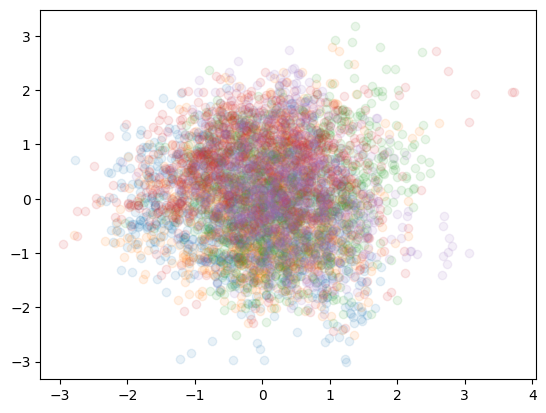

In [ ]:
for i in range(5):
    plt.scatter(x0[:, i, 0].detach().cpu(), x0[:, i, 1].detach().cpu(), alpha=0.1)


## Training

### Dataset

In [19]:
from typing import NamedTuple, Optional, Union, Tuple
from pathlib import Path
class FullGraphSample(NamedTuple):
    positions: torch.Tensor
    features: torch.Tensor

    def __getitem__(self, i):
        return FullGraphSample(self.positions[i], self.features[i])


def positional_dataset_only_to_full_graph(positions) -> FullGraphSample:
    """Convert positional dataset into full graph by using zeros for features. Assumes data is only for x, and not
    augmented coordinates."""
    features = torch.zeros((*positions.shape[:-1], 1), dtype=int)
    return FullGraphSample(positions=positions, features=features)

In [20]:
def load_lj13(
    train_set_size: int = 1000, path = None
) -> Tuple[FullGraphSample, FullGraphSample, FullGraphSample]:
    # dataset from https://github.com/vgsatorras/en_flows
    # Loading following https://github.com/vgsatorras/en_flows/blob/main/dw4_experiment/dataset.py.

    # Train data
    if path is None:
        here = Path(__file__).parent
        path = here / "data"
    path = Path(path)
    fpath_train = path / "holdout_data_LJ13.npy"
    fpath_idx = path / "idx_LJ13.npy"
    fpath_val_test = path / "all_data_LJ13.npy"

    train_data = torch.tensor(np.load(fpath_train, allow_pickle=True))
    
    idxs = np.load(fpath_idx, allow_pickle=True)
    val_test_data = torch.tensor(np.load(fpath_val_test, allow_pickle=True))

    val_data = val_test_data[1000:2000]
    test_data = val_test_data[:1000]

    assert train_set_size <= len(idxs)
    train_data = train_data[idxs[:train_set_size]]
    
    val_data = np.reshape(val_data, (-1, 13, 3))
    test_data = np.reshape(test_data, (-1, 13, 3))
    train_data = np.reshape(train_data, (-1, 13, 3))
    return (
        positional_dataset_only_to_full_graph(train_data),
        positional_dataset_only_to_full_graph(val_data),
        positional_dataset_only_to_full_graph(test_data),
    )

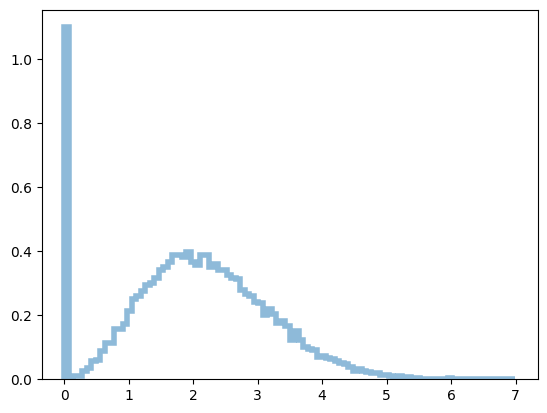

In [21]:
beta = 1
n_samples = 512

n_nodes = 13
dim = 3

centers = torch.zeros((n_samples, n_nodes*dim), device=device)
init_samples = torch.normal(centers, torch.full_like(centers, fill_value=beta))
init_energy = log_prob(init_samples.reshape(-1, n_nodes, dim))
init_dists = interatomic_dist(init_samples.reshape(-1, n_nodes, dim))
plt.hist(init_dists.view(-1).cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4)
plt.show()

### Model

In [22]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, beta):
        super().__init__()
        self.score = score
        self.beta = beta
    
    def f(self, t, x):
        with torch.enable_grad():
            if t.dim() == 0:
                # repeat the same time for all points if we have a scalar time
                t = t * torch.ones(x.shape[0]).to(device)
        
            x.requires_grad = True
            score = self.score((1-t).unsqueeze(-1), x)

            norm = torch.linalg.vector_norm(score, dim=-1)
            #print(norm.max())
            max_norm = 100
            clip_coef = torch.clamp(max_norm / (norm+1e-6), max=1)
            score = score * clip_coef.unsqueeze(-1)

        return self.g(t, x)**2 * score 
    
    def g(self, t, x):
        return torch.full_like(x, self.beta ** 0.5)

### Helpers

In [23]:
import math
def center_gravity_zero_gaussian_log_likelihood(x):
    N, D = x.shape[-2:]

    # r is invariant to a basis change in the relevant hyperplane.
    r2 = torch.sum(x**2, dim=(-1, -2))

    # The relevant hyperplane is (N-1) * D dimensional.
    degrees_of_freedom = (N-1) * D

    # Normalizing constant and logpx are computed:
    log_normalizing_constant = -0.5 * degrees_of_freedom * math.log(2*torch.pi)
    log_px = -0.5 * r2 + log_normalizing_constant

    return log_px

In [24]:
def sample_from_array(array, size):
    idx = np.random.choice(array.shape[0], size=size)
    return array[idx]

In [25]:
def sample_centered_gaussian(shape):
    samples = torch.randn(shape)
    samples = samples - samples.mean(-2, keepdims=True)
    return samples
def sample_data(data, batch_size):
    idx = torch.randint(0,8000, (batch_size, ))
    return data[idx].positions

In [26]:
# samples_all = np.load('data/all_data_LJ13-2.npy')
# test_data = samples_all[len(samples_all)//2:]
# train_data = samples_all[:len(samples_all)//2]

test_data = np.load('data/all_data_LJ13.npy')[:1000]
train_data = np.load('data/holdout_data_LJ13.npy')

train_data = torch.tensor(train_data, device=device)
test_data = torch.tensor(test_data, device=device)

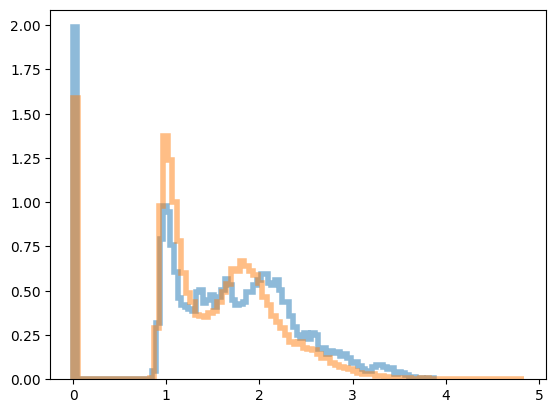

In [27]:
test_dists = interatomic_dist(test_data.reshape(-1, n_nodes, dim))
plt.hist(test_dists.view(-1).cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4)

train_dists = interatomic_dist(sample_from_array(train_data, 1000).reshape(-1, n_nodes, dim))
plt.hist(train_dists.view(-1).cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4)
plt.show()

### Training

In [28]:
def cfm_inference(model, xt, t, dt):
    with torch.no_grad():
        vt = model(t, xt)
        xt_new = xt + vt * dt
        return xt_new

In [29]:
def generate_samples_ode(model, x_init, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt).to(device)
    samples = []
    x = x_init
    with torch.no_grad():
        for t in times:
            x = cfm_inference(model, x, t, 1e-3)
            samples.append(x)
    return torch.stack(samples)

In [30]:
def cfm_loss(model, x1):
    x1 = x1.reshape(-1, 13, 3)
    x0 = sample_centered_gaussian((x1.shape[0], 13, 3)).to(device)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
    xt = xt.reshape(-1, 39)
    ut = ut.reshape(-1, 39)

    # xt_centered = xt - xt.mean(dim=-2, keepdims=True)

    vt = model(t[:, None], xt)
    loss = torch.mean((vt - ut) ** 2)
    return loss

In [31]:
def reward_matching_loss_biased(model, x, t, beta):     
    t = t.unsqueeze(1)
    h_t = beta * t
    x.requires_grad = True

    # noisy sample: x(t)
    # x =  x - x.mean(dim=-2, keepdims=True)
    noisy_x = torch.normal(x, h_t ** 0.5)
    pred_scores = model(t, noisy_x)

    #estimated_scores = torch.vmap(estimate_grad_Rt, in_dims=(0,0,None), randomness="different")(noisy_x, t.squeeze(), beta)
    estimated_scores = estimate_grad_Rt(noisy_x, t.squeeze(), beta)
    return ((estimated_scores - pred_scores)**2).mean()

In [32]:
def score_loss(vectorfield, x, t):
    h_t = beta * t.unsqueeze(1)
    # x(t)
    x_t = torch.normal(x, h_t ** 0.5)
    s_pred = vectorfield(t.unsqueeze(1), x_t)

    s_true = - (x_t - x)/ h_t 
    return ((s_pred - s_true)**2).mean()    

In [33]:
model = EGNN_dynamics(n_particles=n_nodes, device=device,  n_dimension=dim, hidden_nf=32, 
                      act_fn=torch.nn.SiLU(), n_layers=3, recurrent=True, tanh=True, 
                      attention=True, condition_time=True, agg='sum')
amodel = AugmentedVectorField(model, [CNFReg("exact")], dim=(n_nodes, dim))
node = NeuralODE(amodel, solver="euler")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [34]:
from torchcfm.conditional_flow_matching import ConditionalFlowMatcher
FM = ConditionalFlowMatcher(sigma=0.0)

In [35]:
# Initialize the buffer with some initial samples
buff_init_samples = sample_from_array(train_data, 2000)
buff_init_energy = log_prob(buff_init_samples.reshape(-1, n_nodes, dim))

buffer = SimpleBuffer(n_nodes*dim, 10000, 1000, initial_sampler=None, 
                      device=device, fill_buffer_during_init=False, sample_with_replacement=True)

buffer.add(buff_init_samples, buff_init_energy)

Buffer not initialised, expected that checkpoint will be loaded.


Outer Epoch 0 | Inner Epoch 0 | Loss 7.743215
Outer Epoch 0 | Inner Epoch 49 | Loss 19.087440
Outer Epoch 0 | Inner Epoch 98 | Loss 5.757240


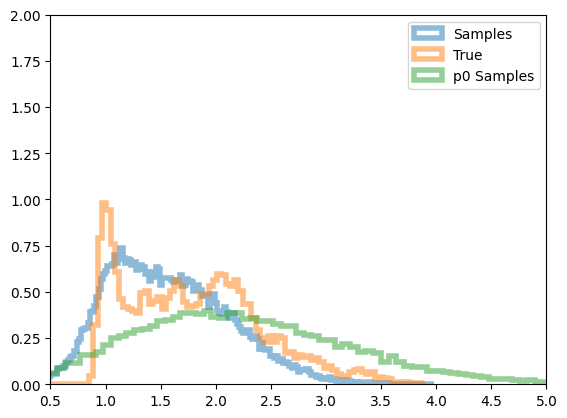

Epoch 0| Test NLL: 106.21, Train NLL: 61.83
Outer Epoch 1 | Inner Epoch 0 | Loss 4.600721
Outer Epoch 1 | Inner Epoch 49 | Loss 13.986409
Outer Epoch 1 | Inner Epoch 98 | Loss 8.062151
Outer Epoch 2 | Inner Epoch 0 | Loss 8.655273
Outer Epoch 2 | Inner Epoch 49 | Loss 3.617954
Outer Epoch 2 | Inner Epoch 98 | Loss 3.934303


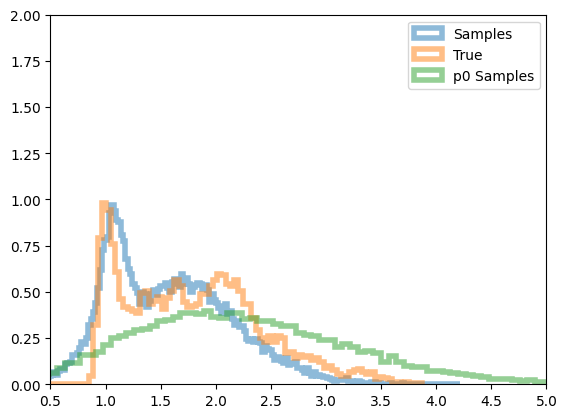

Epoch 2| Test NLL: 76.06, Train NLL: 53.80
Outer Epoch 3 | Inner Epoch 0 | Loss 12.075473
Outer Epoch 3 | Inner Epoch 49 | Loss 7.715985
Outer Epoch 3 | Inner Epoch 98 | Loss 3.150754
Outer Epoch 4 | Inner Epoch 0 | Loss 6.096984
Outer Epoch 4 | Inner Epoch 49 | Loss 6.782228
Outer Epoch 4 | Inner Epoch 98 | Loss 18.815941


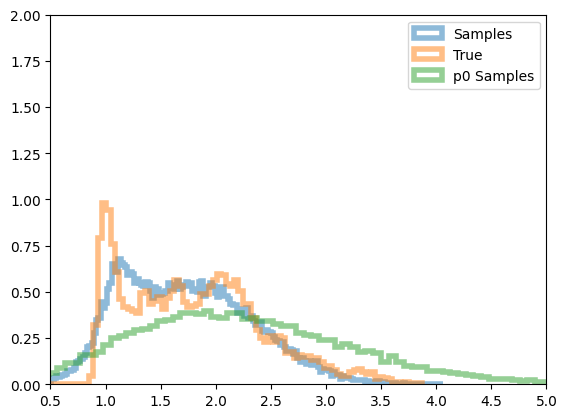

Epoch 4| Test NLL: 116.99, Train NLL: 56.74
Outer Epoch 5 | Inner Epoch 0 | Loss 5.180208
Outer Epoch 5 | Inner Epoch 49 | Loss 5.145849
Outer Epoch 5 | Inner Epoch 98 | Loss 6.312563
Outer Epoch 6 | Inner Epoch 0 | Loss 7.203189
Outer Epoch 6 | Inner Epoch 49 | Loss 7.204988
Outer Epoch 6 | Inner Epoch 98 | Loss 6.826276


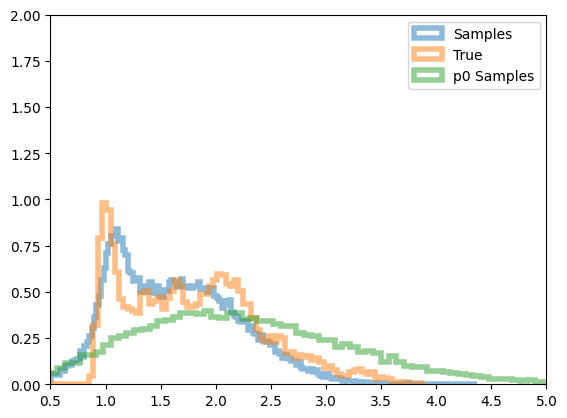

Epoch 6| Test NLL: 110.95, Train NLL: 75.90
Outer Epoch 7 | Inner Epoch 0 | Loss 7.592890
Outer Epoch 7 | Inner Epoch 49 | Loss 6.341938
Outer Epoch 7 | Inner Epoch 98 | Loss 5.080778
Outer Epoch 8 | Inner Epoch 0 | Loss 5.046705
Outer Epoch 8 | Inner Epoch 49 | Loss 8.866585
Outer Epoch 8 | Inner Epoch 98 | Loss 10.251798


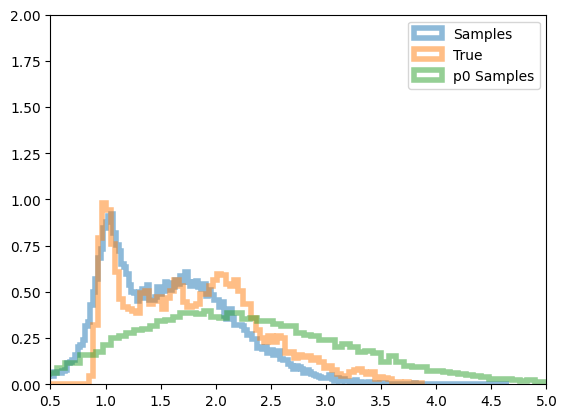

Epoch 8| Test NLL: 81.79, Train NLL: 59.95
Outer Epoch 9 | Inner Epoch 0 | Loss 19.029758
Outer Epoch 9 | Inner Epoch 49 | Loss 7.629988
Outer Epoch 9 | Inner Epoch 98 | Loss 7.625751
Outer Epoch 10 | Inner Epoch 0 | Loss 8.126801
Outer Epoch 10 | Inner Epoch 49 | Loss 8.948397
Outer Epoch 10 | Inner Epoch 98 | Loss 4.750890


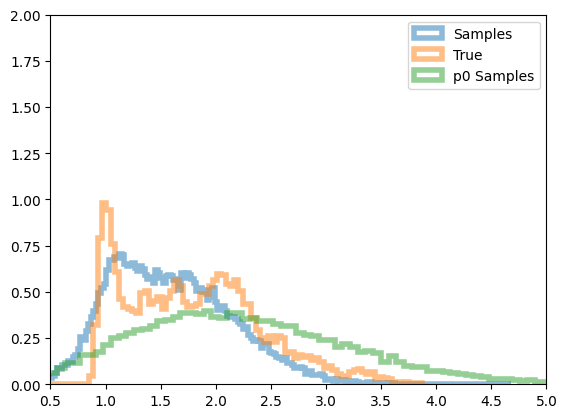

Epoch 10| Test NLL: 93.65, Train NLL: 58.35
Outer Epoch 11 | Inner Epoch 0 | Loss 6.239714
Outer Epoch 11 | Inner Epoch 49 | Loss 8.598863
Outer Epoch 11 | Inner Epoch 98 | Loss 4.451088
Outer Epoch 12 | Inner Epoch 0 | Loss 5.706331
Outer Epoch 12 | Inner Epoch 49 | Loss 9.920368
Outer Epoch 12 | Inner Epoch 98 | Loss 15.341713


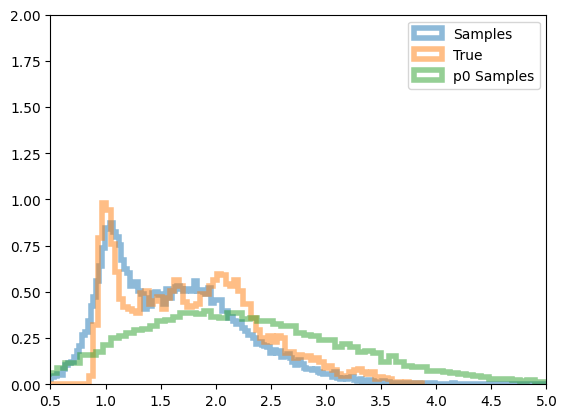

Epoch 12| Test NLL: 80.29, Train NLL: 48.35
Outer Epoch 13 | Inner Epoch 0 | Loss 4.302679
Outer Epoch 13 | Inner Epoch 49 | Loss 9.687751
Outer Epoch 13 | Inner Epoch 98 | Loss 3.916755
Outer Epoch 14 | Inner Epoch 0 | Loss 108.248169
Outer Epoch 14 | Inner Epoch 49 | Loss 3.652444
Outer Epoch 14 | Inner Epoch 98 | Loss 5.360426


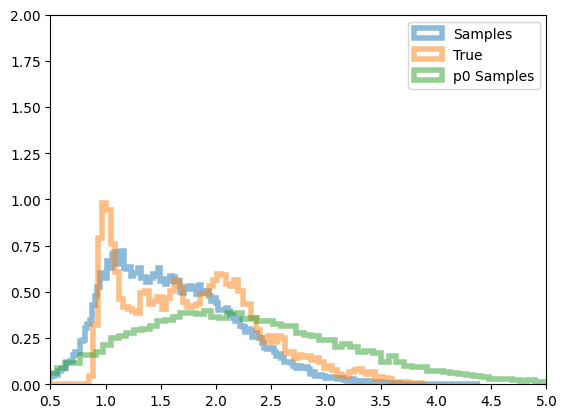

Epoch 14| Test NLL: 92.19, Train NLL: 60.39
Outer Epoch 15 | Inner Epoch 0 | Loss 7.402242
Outer Epoch 15 | Inner Epoch 49 | Loss 6.026537
Outer Epoch 15 | Inner Epoch 98 | Loss 4.786431
Outer Epoch 16 | Inner Epoch 0 | Loss 6.829500
Outer Epoch 16 | Inner Epoch 49 | Loss 5.205650
Outer Epoch 16 | Inner Epoch 98 | Loss 4.089345


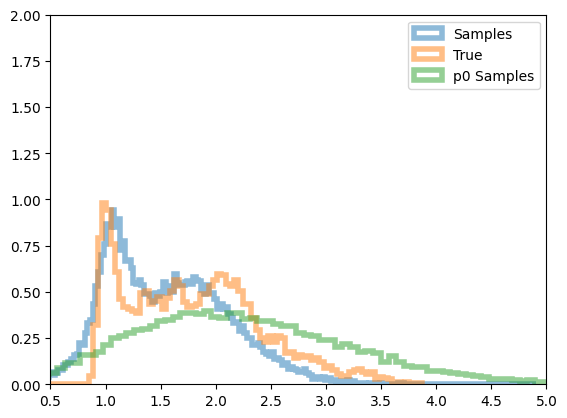

Epoch 16| Test NLL: 74.60, Train NLL: 52.63
Outer Epoch 17 | Inner Epoch 0 | Loss 5.379404
Outer Epoch 17 | Inner Epoch 49 | Loss 6.792023
Outer Epoch 17 | Inner Epoch 98 | Loss 4.783121
Outer Epoch 18 | Inner Epoch 0 | Loss 15.341212
Outer Epoch 18 | Inner Epoch 49 | Loss 4.635523
Outer Epoch 18 | Inner Epoch 98 | Loss 8.825352


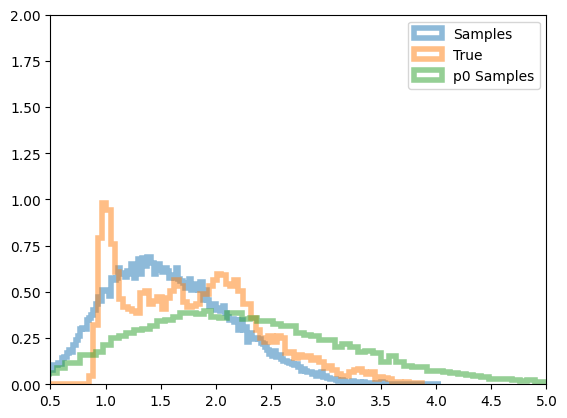

Epoch 18| Test NLL: 67.89, Train NLL: 48.27
Outer Epoch 19 | Inner Epoch 0 | Loss 4.764443
Outer Epoch 19 | Inner Epoch 49 | Loss 8.693316
Outer Epoch 19 | Inner Epoch 98 | Loss 5.134517
Outer Epoch 20 | Inner Epoch 0 | Loss 5.197217
Outer Epoch 20 | Inner Epoch 49 | Loss 5.540194
Outer Epoch 20 | Inner Epoch 98 | Loss 5.037604


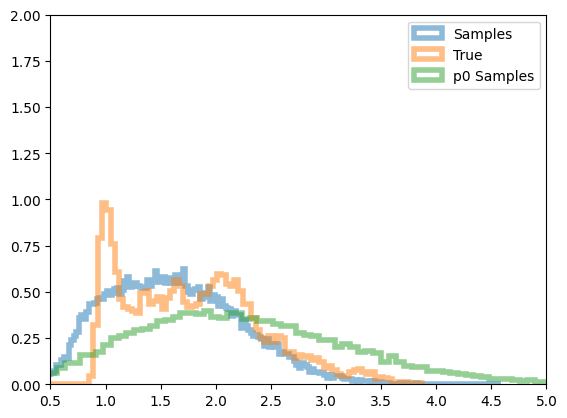

KeyboardInterrupt: 

In [36]:
outer_epochs= 1000
inner_epochs = 100

num_samples = 2048 
batch_size = 512

# train_dataset = TensorDataset(init_samples.clone(), init_energy.clone())
train_dataset = TensorDataset(buff_init_samples.clone(), buff_init_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) 
x1_samples, x1_energy = init_samples.clone(), init_energy.clone()

for epoch in range(outer_epochs):
    for k in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            # perm = torch.randperm(train_data.shape[0])
            # idx = perm[:batch_size]
            # x1 = train_data[idx].reshape(-1, 13, 3)
            # samples = samples.to(device)
            
            optimizer.zero_grad()

            t = torch.rand(len(samples), device=device)

            # low_time_t = (-0.1 * torch.rand(len(samples), device=device)) + 0.1
            # high_time_t = (-0.9 * torch.rand(len(samples), device=device)) + 1.0
            # mask = torch.rand(len(samples), device=device) < 0.8
            # t = (low_time_t * mask) + (high_time_t * ~mask)

            loss = score_loss(model, samples, t) # + reward_matching_loss_biased(model, samples, t, beta)
            # loss = cfm_loss(model, x1)

            loss.backward()
            optimizer.step()
            
        if k % 49 == 0:
            print("Outer Epoch %d | Inner Epoch %d | Loss %f" % (epoch, k, loss.item()))


    # Generate samples using the vector field
    ve_reverse_sde = VEReverseSDE(model, beta)
    # gen_samples = integrate_sde(ve_reverse_sde, x1_samples, [0, 1], 1e-3)[-1]
    samples = generate_samples(ve_reverse_sde, x1_samples)[-1]
    samples_energy = log_prob(samples).detach()

    # Update Buffer with generated samples
    buffer.add(samples, samples_energy)

    # Run inference for plotting and NLL calculation
    if epoch % 2 == 0:
        # x1_samples = sample_centered_gaussian((100, 13, 3)).to(device).reshape(-1, 39)
        # samples = generate_samples_ode(model, x1_samples_cfm, [0, 1], 1e-3)[-1]

        dist_samples = interatomic_dist(samples.reshape(-1, n_nodes, dim))
        dist_x1 = interatomic_dist(x1_samples.reshape(-1, n_nodes, dim))
        plt.hist(dist_samples.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, 
                 density=True, histtype='step', linewidth=4, label='Samples')
        plt.hist(test_dists.view(-1).detach().cpu().numpy(), bins=100, alpha=0.5, 
                 density=True, histtype='step', linewidth=4, label='True') 
        plt.hist(dist_x1.view(-1).detach().cpu().numpy(), bins=100, alpha=0.5, 
                 density=True, histtype='step', linewidth=4, label='p0 Samples')
        plt.xlim(0.5, 5)
        plt.ylim(0, 2)
        plt.legend()
        plt.show()

        with torch.no_grad():
            x0 = node.trajectory(torch.cat([torch.zeros((1000, 1)).to(device), test_data[:1000].reshape(-1, 39)], dim=1)[:10],
                                t_span = torch.linspace(1, 0, 21).to(device))
            x0_centered = x0[-1, :, 1:]
            x0_centered = x0_centered.reshape(-1, 13, 3)
            x0_centered = x0_centered - x0_centered.mean(dim=-2, keepdims=True)
            
            nll = -(center_gravity_zero_gaussian_log_likelihood(x0_centered) - x0[-1,:, 0])

            x0_train = node.trajectory(torch.cat([torch.zeros((1000, 1)).to(device),
                                                   train_data[:1000].reshape(-1, 39)], dim=1)[:10],
                                        t_span = torch.linspace(1, 0, 21).to(device))
            x0_centered = x0_train[-1, :, 1:]
            x0_centered = x0_centered.reshape(-1, 13, 3)
            x0_centered = x0_centered - x0_centered.mean(dim=-2, keepdims=True)
            nll_train = -(center_gravity_zero_gaussian_log_likelihood(x0_centered) - x0_train[-1,:, 0])
            print("Epoch " + str(epoch) + "| Test NLL:","{:.2f},".format(nll.mean().item()), 
                  "Train NLL:", "{:.2f}".format(nll_train.mean().item()))


    # Resample data from the buffer
    # samples, samples_energy, _ = buffer.sample(512 * 5)
    # train_dataset = TensorDataset(samples, samples_energy)
    # trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)